# Telecom Customer Churn Prediction Model

📌 1. Project Overview

Goal:
To build a predictive model that identifies customers likely to churn (discontinue service) for a telecom company.

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt

📂 Load and Explore the Dataset

In [2]:
# Loading and cleaning data
data = pd.read_csv("Telco-Customer-Churn.csv")
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
#data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
data.dtypes

,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


In [5]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


📊 Churn Distribution

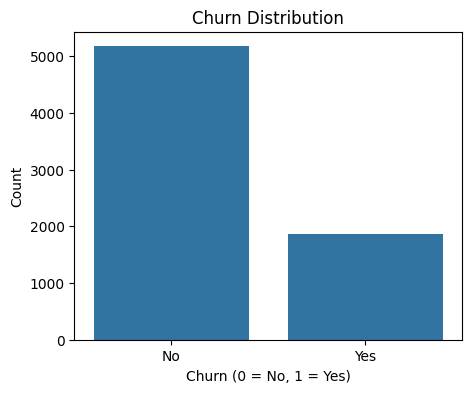

In [6]:
#plotting churn distribution
plt.figure(figsize=(5,4))
sns.countplot(x='Churn', data=data)
plt.title("Churn Distribution")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

In [7]:
# Convert TotalCharges to numeric and handle missing values
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce")
data["TotalCharges"].fillna(data["TotalCharges"].mean(), inplace=True)

# Drop customerID (not useful for modelling)
data.drop("customerID", axis=1, inplace=True)

/tmp/ipython-input-1146677474.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["TotalCharges"].fillna(data["TotalCharges"].mean(), inplace=True)


In [8]:
# Encoding categorical features

binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
label = LabelEncoder()
for col in binary_cols:
    data[col] = label.fit_transform(data[col])

# One hot encoding categorical columns
data = pd.get_dummies(data, drop_first=True)

In [9]:
# Feature Engineering
data['tenure_monthlycharges'] = data['tenure'] * data['MonthlyCharges']
data['tenure_contract'] = data['tenure'] * data['Contract_Two year']
data['avg_charge_per_tenure'] = data['TotalCharges'] / (data['tenure'] + 1)
data['is_long_term'] = (data['tenure'] > 12).astype(int)

In [10]:
# Splitting data into training,validation and testing
x = data.drop("Churn", axis=1)
y = data["Churn"]

x_train_full, x_test, y_train_full, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.25, random_state=42)


# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

In [11]:
#Scaling data
scaler = StandardScaler()
x_train_smote = scaler.fit_transform(x_train_smote)
x_val=scaler.transform(x_val)
x_test = scaler.transform(x_test)

Model Training & Validation

In [12]:
#model for logistic regression
lr=LogisticRegression(class_weight="balanced", random_state=42)
lr.fit(x_train_smote, y_train_smote)
y_pred = lr.predict(x_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val,y_pred))

Accuracy: 0.759403832505323
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1030
           1       0.55      0.62      0.58       379

    accuracy                           0.76      1409
   macro avg       0.70      0.72      0.71      1409
weighted avg       0.77      0.76      0.76      1409



In [13]:
#model for decision tree classifier
dt=DecisionTreeClassifier(class_weight="balanced", random_state=42)
dt.fit(x_train_smote, y_train_smote)
y_pred = dt.predict(x_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Accuracy: 0.709013484740951
              precision    recall  f1-score   support

           0       0.82      0.77      0.80      1030
           1       0.46      0.53      0.50       379

    accuracy                           0.71      1409
   macro avg       0.64      0.65      0.65      1409
weighted avg       0.72      0.71      0.71      1409



In [14]:
#model for random forest classifier
rf=RandomForestClassifier(class_weight="balanced", random_state=42)
rf.fit(x_train_smote, y_train_smote)
y_pred = rf.predict(x_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Accuracy: 0.7757274662881476
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1030
           1       0.58      0.58      0.58       379

    accuracy                           0.78      1409
   macro avg       0.71      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409



In [15]:
#model for gradient boosting classifier
gb=GradientBoostingClassifier(random_state=42)
gb.fit(x_train_smote, y_train_smote)
y_pred = gb.predict(x_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Accuracy: 0.7778566359119943
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1030
           1       0.57      0.68      0.62       379

    accuracy                           0.78      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.79      0.78      0.78      1409



🔧Hyperparameter Tuning for Gradient Boosting

In [16]:
#Hyperparameter Tuning for gradient boosting
param_grid = {"n_estimators": [100, 200, 300],"learning_rate": [0.01, 0.05, 0.1],"max_depth": [3, 4, 5]}

grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring="recall"
)
grid_search.fit(x_train_smote, y_train_smote)

best_gb = grid_search.best_estimator_
print("\nBest Parameters from GridSearchCV:", grid_search.best_params_)

#Evaluate Tuned Gradient Boosting
y_pred = best_gb.predict(x_val)
y_prob = best_gb.predict_proba(x_val)[:, 1]

print("\n Tuned Gradient Boosting Results")
print("Accuracy:", accuracy_score(y_val, y_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_prob))
print(classification_report(y_val, y_pred))


Best Parameters from GridSearchCV: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200}

 Tuned Gradient Boosting Results
Accuracy: 0.7814052519517388
ROC-AUC: 0.8291940979071137
              precision    recall  f1-score   support

           0       0.87      0.82      0.85      1030
           1       0.58      0.66      0.62       379

    accuracy                           0.78      1409
   macro avg       0.73      0.74      0.73      1409
weighted avg       0.79      0.78      0.79      1409



In [17]:
#Final training and evaluation
x_train_df = pd.DataFrame(x_train, columns=x.columns)
x_val_df = pd.DataFrame(x_val, columns=x.columns)

x_trainval = pd.concat([x_train_df, x_val_df])
y_trainval = pd.concat([y_train, y_val])

x_trainval_smote, y_trainval_smote = smote.fit_resample(x_trainval, y_trainval)

x_trainval_scaled = scaler.fit_transform(x_trainval_smote)
x_test_scaled = scaler.transform(x_test)

best_gb.fit(x_trainval_scaled, y_trainval_smote)
y_pred = best_gb.predict(x_test_scaled)
y_prob = best_gb.predict_proba(x_test_scaled)[:, 1]

print("\nFinal Tuned Gradient Boosting Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Final Tuned Gradient Boosting Results
Accuracy: 0.7927608232789212
ROC-AUC: 0.8443500470980363
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1036
           1       0.60      0.67      0.63       373

    accuracy                           0.79      1409
   macro avg       0.74      0.75      0.74      1409
weighted avg       0.80      0.79      0.80      1409



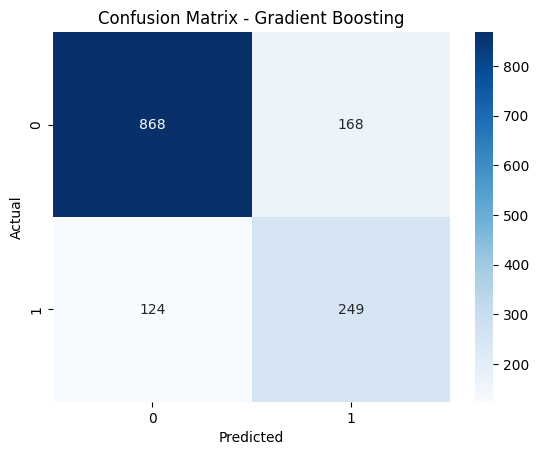

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

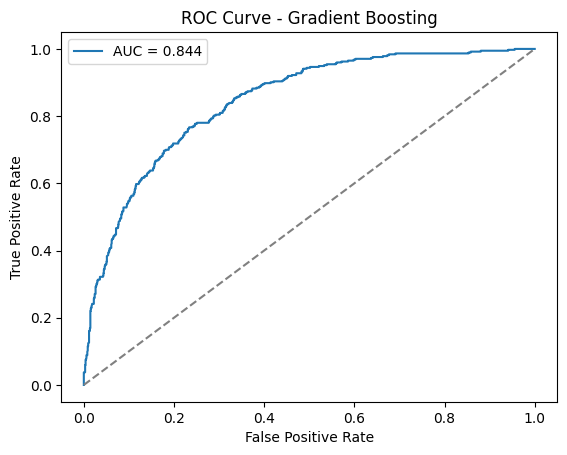

In [19]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Gradient Boosting")
plt.legend()
plt.show()

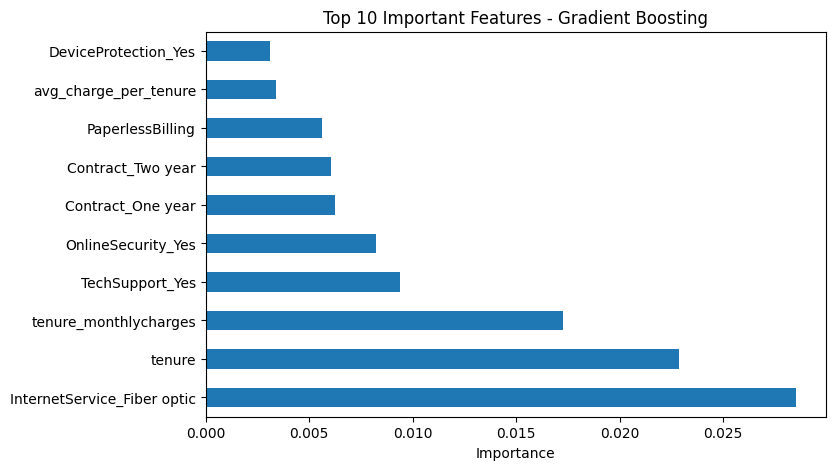


Top 10 Important Features:
InternetService_Fiber optic    0.028531
tenure                         0.022853
tenure_monthlycharges          0.017246
TechSupport_Yes                0.009368
OnlineSecurity_Yes             0.008233
Contract_One year              0.006246
Contract_Two year              0.006033
PaperlessBilling               0.005607
avg_charge_per_tenure          0.003407
DeviceProtection_Yes           0.003123
dtype: float64


In [20]:
#Permutation Importance for features
importance = permutation_importance(best_gb, x_test_scaled, y_test, n_repeats=10, random_state=42)
perm_imp = pd.Series(importance.importances_mean, index=x.columns)
perm_imp.nlargest(10).plot(kind="barh", figsize=(8, 5))
plt.title("Top 10 Important Features - Gradient Boosting")
plt.xlabel("Importance")
plt.show()

print("\nTop 10 Important Features:")
print(perm_imp.nlargest(10))

## 🏁Insights & Conclusion

Best Model: Tuned Gradient Boosting Classifier

Test Accuracy: 0.79

ROC-AUC Score: 0.844

### Key Features of Churn Prediction:

Fiber Optics in Internet Service

Tenure

Monthly Charges

Tech Support availability and Online Support Availability

Contract Type